In [1]:
import torch
import os
from dataPreprocessing import *
import pandas as pd
import numpy as np

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 64

torch.manual_seed(RANDOM_SEED)

In [3]:
#folder path were dataset is located
path = 'dataset/'
#initialize empty lists to hold data
train_pos, train_neg, test_pos, test_neg = [], [], [], []
#create a dictionary where the key is the relative path to data and value is empty list
sets_dict = {'train/pos/': train_pos, 'train/neg/': train_neg, 'test/pos/': test_pos, 'test/neg/': test_neg}
#loop through dictionary to read from files and populate empty lists
for dataset in sets_dict:
        file_list = [file for file in os.listdir(os.path.join(path, dataset)) if file.endswith('.txt')]
        file_list = sorted(file_list)
        load_data(os.path.join(path, dataset), file_list, sets_dict[dataset])
#Covert lists to pandas dataframes and combine to form train and test datasets
train_data = pd.concat([pd.DataFrame({'review': train_pos, 'label':1}), pd.DataFrame({'review': train_neg, 'label':0})], axis = 0, ignore_index=True)
test_data = pd.concat([pd.DataFrame({'review': test_pos, 'label':1}), pd.DataFrame({'review': test_neg, 'label':0})], axis = 0, ignore_index=True)

In [4]:
test_data["tokenized"] = test_data["review"].apply(lambda x: tokenize(clean_text(x.lower())))
#Examine tokenized reviews
print(test_data.head()["tokenized"])

0    [i, went, and, saw, this, movie, last, night, ...
1    [actor, turned, director, bill, paxton, follow...
2    [as, a, recreational, golfer, with, some, know...
3    [i, saw, this, film, in, a, sneak, preview, ,,...
4    [bill, paxton, has, taken, the, true, story, o...
Name: tokenized, dtype: object


In [5]:
def pad_or_trim(tokens, length=400, pad_token=""):
    """Pads or trims a list of tokens to a specified length."""
    if len(tokens) > length:
        # Trim the list to the desired length
        return tokens[:length]
    else:
        # Pad the list with the pad_token
        return tokens + [pad_token] * (length - len(tokens))

# Apply the function to create the tokenized column
test_data["tokenized"] = test_data["review"].apply(
    lambda x: pad_or_trim(tokenize(clean_text(x.lower())))
)

# Verify the length of each tokenized review
print(test_data["tokenized"].apply(len).value_counts())

tokenized
400    25000
Name: count, dtype: int64


In [24]:
print(test_data.head()["tokenized"][3])

['i', 'saw', 'this', 'film', 'in', 'a', 'sneak', 'preview', ',', 'and', 'it', 'is', 'delightful', '.', 'the', 'cinematography', 'is', 'unusually', 'creative', ',', 'the', 'acting', 'is', 'good', ',', 'and', 'the', 'story', 'is', 'fabulous', '.', 'if', 'this', 'movie', 'does', 'not', 'do', 'well', ',', 'it', 'wo', "n't", 'be', 'because', 'it', 'does', "n't", 'deserve', 'to', '.', 'before', 'this', 'film', ',', 'i', 'did', "n't", 'realize', 'how', 'charming', 'shia', 'lebouf', 'could', 'be', '.', 'he', 'does', 'a', 'marvelous', ',', 'self', '-', 'contained', ',', 'job', 'as', 'the', 'lead', '.', 'there', "'s", 'something', 'incredibly', 'sweet', 'about', 'him', ',', 'and', 'it', 'makes', 'the', 'movie', 'even', 'better', '.', 'the', 'other', 'actors', 'do', 'a', 'good', 'job', 'as', 'well', ',', 'and', 'the', 'film', 'contains', 'moments', 'of', 'really', 'high', 'suspense', ',', 'more', 'than', 'one', 'might', 'expect', 'from', 'a', 'movie', 'about', 'golf', '.', 'sports', 'movies', 'ar

In [8]:
# Load the .pt files
file_path_a = os.path.join('model_weights', 'ksae_latent_activations_a.pt')
file_path_b = os.path.join('model_weights', 'ksae_latent_activations_b.pt')
data_a = torch.load(file_path_a)
data_b = torch.load(file_path_b)
# Combine the tensors along the first dimension (dim=0)
data = torch.cat((data_a, data_b), dim=0)
print(data.shape)

torch.Size([10000000, 64])


In [9]:
# Reshape the data (25000 reviews, 400 tokens, 64 features)
data = data.reshape(25000, 400, 64)

# Compute the maximum weight for each feature across all tokens (dim=1 aggregates across tokens)
max_weights = data.max(dim=1).values  # Shape: (25000, 64)

# Print the maximum weight for each feature across all tokens
print(max_weights)

# If you want to further summarize it (e.g., max weight per feature across all reviews), you can use:
max_weights_per_feature = max_weights.max(dim=0).values  # Shape: (64,)
print("Maximum weight for each feature across all tokens and reviews:")
print(max_weights_per_feature)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MaxBackward0>)
Maximum weight for each feature across all tokens and reviews:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9116,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.5946, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.6567, 0.0000, 0.0000, 0.0000,
        3.6830, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2205,
        0.0000, 0.0000, 1.3032, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        3.5435, 0.0000, 0.0000, 3.7736, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<MaxBackward0>)


In [15]:
print(data[0][0])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.8268,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7730, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.3667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1146,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<SelectBackward0>)


In [25]:
print(data[3][12])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4002, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0636, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1176,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6853, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<SelectBackward0>)


In [26]:
print(data[3][14])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6333,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.8284, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2163,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        2.5615, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<SelectBackward0>)


In [11]:
def get_max_tokens(feature_number, data, tokenized_data):
    """
    Prints the tokens with the maximum activation for a given feature across all reviews,
    along with their activation values.

    Parameters:
    - feature_number: int, the feature index to analyze (0-63).
    - data: tensor of shape (25000, 400, 64) containing activations.
    - tokenized_data: list of tokenized reviews (each review is a list of 400 tokens).
    """

    # Ensure the feature number is within valid range
    if feature_number < 0 or feature_number >= data.shape[2]:
        raise ValueError(f"Feature number must be between 0 and {data.shape[2] - 1}")

    # Extract the activations for the given feature across all tokens and reviews
    activations = data[:, :, feature_number]  # Shape: (25000, 400)

    # Find the index of the maximum activation per review
    max_token_indices = activations.argmax(dim=1)  # Shape: (25000,)

    # Collect the corresponding tokens with max activation for each review
    max_tokens = [
        (tokenized_data[i][max_token_indices[i].item()], activations[i, max_token_indices[i]].item())
        for i in range(len(tokenized_data))
    ]

    # Print the tokens with the highest activation for the specified feature
    print(f"Tokens with max activation for feature {feature_number}:")
    for i, (token, activation) in enumerate(max_tokens[:10]):  # Show first 10 results for brevity
        print(f"Review {i + 1}: Token = '{token}', Activation = {activation:.4f}")

# Example usage:
# Assume `test_data["tokenized"]` contains the tokenized reviews.
tokenized_data = test_data["tokenized"].tolist()
get_max_tokens(8, data, tokenized_data)  # Replace 0 with the feature number you want to analyze.

Tokens with max activation for feature 8:
Review 1: Token = '', Activation = 3.8465
Review 2: Token = 'atmosphere', Activation = 3.7653
Review 3: Token = '', Activation = 3.8912
Review 4: Token = '', Activation = 3.8846
Review 5: Token = 'is', Activation = 3.6167
Review 6: Token = 'gentlemen', Activation = 3.7947
Review 7: Token = 'the', Activation = 3.7016
Review 8: Token = 'convincingly', Activation = 3.8120
Review 9: Token = '', Activation = 3.8569
Review 10: Token = ',', Activation = 3.6208


In [37]:
import matplotlib.pyplot as plt
import numpy as np

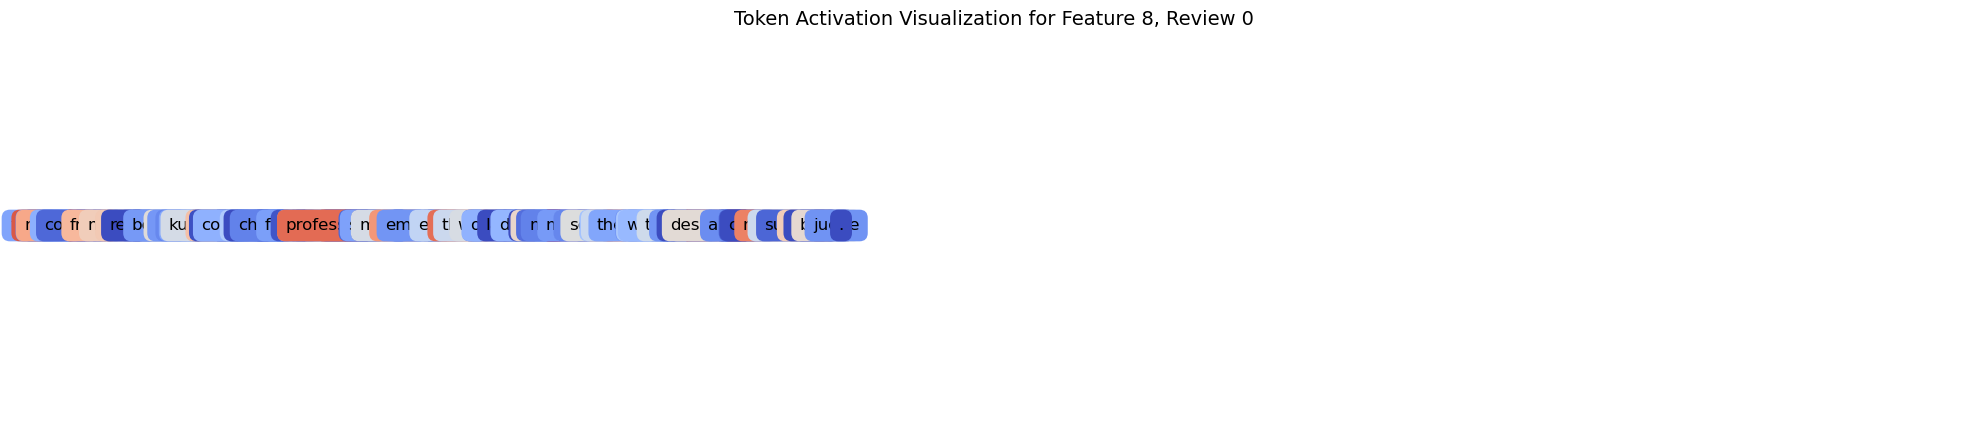

In [45]:
def plot_colored_tokens_with_more_spacing(feature_number, review_number, data, tokenized_data):
    """
    Plots tokens with color-coded backgrounds based on their activation values,
    with more spacing between tokens and using a blue-to-red colormap (cool to hot).

    Parameters:
    - feature_number: int, the feature index to analyze (0-63).
    - review_number: int, the review index to analyze (0-24999).
    - data: tensor of shape (25000, 400, 64) containing activations.
    - tokenized_data: list of tokenized reviews (each review is a list of 400 tokens).
    """

    # Ensure feature and review numbers are within valid ranges
    if feature_number < 0 or feature_number >= data.shape[2]:
        raise ValueError(f"Feature number must be between 0 and {data.shape[2] - 1}")
    if review_number < 0 or review_number >= data.shape[0]:
        raise ValueError(f"Review number must be between 0 and {data.shape[0] - 1}")

    # Extract activations for the given feature and review
    activations = data[review_number, :, feature_number].detach().numpy()  # Shape: (400,)

    # Normalize activations for color mapping
    norm = plt.Normalize(activations.min(), activations.max())
    cmap = plt.cm.coolwarm  # Blue to red colormap

    # Create the plot with more spacing
    fig, ax = plt.subplots(figsize=(25, 5))  # Increased width for better spacing

    # Adjust spacing between tokens
    x_positions = np.arange(len(tokenized_data[review_number])) * 10  # Add more space between tokens

    # Display tokens with background colors based on their activation
    for i, token in enumerate(tokenized_data[review_number]):
        color = cmap(norm(activations[i]))
        ax.text(x_positions[i], 0.5, token, ha='center', va='center', fontsize=12,
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.5'))

    # Set plot limits and remove axis for a cleaner look
    plt.xlim(-1, x_positions[-1] + 1)
    plt.ylim(0, 1)
    plt.axis('off')

    plt.title(f'Token Activation Visualization for Feature {feature_number}, Review {review_number}', fontsize=14)
    plt.show()

# Example usage:
plot_colored_tokens_with_more_spacing(8, 0, data, tokenized_data)  # Replace with your feature and review numbers.


In [80]:
from IPython.core.display import display, HTML
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def generate_html_colored_tokens(feature_number, review_number, data, tokenized_data):
    """
    Generates HTML to display tokens with color-coded backgrounds based on their activation values.
    Uses a blue-to-red gradient for coloring.

    Parameters:
    - feature_number: int, the feature index to analyze (0-63).
    - review_number: int, the review index to analyze (0-24999).
    - data: tensor of shape (25000, 400, 64) containing activations.
    - tokenized_data: list of tokenized reviews (each review is a list of 400 tokens).
    """

    # Ensure feature and review numbers are within valid ranges
    if feature_number < 0 or feature_number >= data.shape[2]:
        raise ValueError(f"Feature number must be between 0 and {data.shape[2] - 1}")
    if review_number < 0 or review_number >= data.shape[0]:
        raise ValueError(f"Review number must be between 0 and {data.shape[0] - 1}")

    # Extract activations for the given feature and review
    activations = data[review_number, :, feature_number].detach().numpy()  # Shape: (400,)

    # Normalize activations for color mapping
    norm = mcolors.Normalize(activations.min(), activations.max())
    cmap = cm.coolwarm  # Blue-to-red colormap

    # Build the HTML content
    html_content = '<div style="display: flex; flex-wrap: wrap; line-height: 2;">'
    for i, token in enumerate(tokenized_data[review_number]):
        if token:
            color = mcolors.rgb2hex(cmap(norm(activations[i]))[:3])  # Convert to hex color
            html_content += f'<span style="background-color: {color}; padding: 5px 10px; margin: 2px; border-radius: 5px; color:black">{token}</span>'
    html_content += '</div>'

    # Display the HTML content
    display(HTML(html_content))

# Example usage:


/var/folders/p9/_z9hjhnd2md3l8539hwv8t640000gn/T/ipykernel_5357/4109238447.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [87]:
from IPython.core.display import display, HTML
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import torch

def generate_html_top_2_tokens(feature_number, data, tokenized_data):
    """
    Generates HTML to display the top 2 tokens with the highest activations for each review,
    ignoring empty or whitespace-only tokens.
    Uses a blue-to-red gradient for coloring.

    Parameters:
    - feature_number: int, the feature index to analyze (0-63).
    - data: tensor of shape (25000, 400, 64) containing activations.
    - tokenized_data: list of tokenized reviews (each review is a list of 400 tokens).
    """

    # Ensure the feature number is within the valid range
    if feature_number < 0 or feature_number >= data.shape[2]:
        raise ValueError(f"Feature number must be between 0 and {data.shape[2] - 1}")

    # Normalize activations for color mapping
    cmap = cm.coolwarm  # Blue-to-red colormap
    all_activations = data[:, :, feature_number].detach().numpy()  # Extract activations for the feature
    norm = mcolors.Normalize(all_activations.min(), all_activations.max())  # Normalize activations

    # Build the HTML content
    html_content = '<div style="display: flex; flex-wrap: wrap; line-height: 2;">'

    for review_idx, review in enumerate(tokenized_data):
        # Get activations for the current review
        activations = all_activations[review_idx]  # Shape: (400,)

        # Filter out empty or whitespace-only tokens and collect their indices
        valid_tokens = [(i, token) for i, token in enumerate(review) if token.strip()]
        
        # Get the activations corresponding to valid tokens
        valid_activations = [activations[i] for i, _ in valid_tokens]

        # If fewer than 2 valid tokens, skip this review
        if len(valid_activations) < 2:
            continue

        # Find the top 2 valid token indices based on activations
        top_2_indices = sorted(range(len(valid_activations)), key=lambda i: valid_activations[i], reverse=True)[:2]

        # Add the top 2 tokens to the HTML content
        for idx in top_2_indices:
            token_idx, token = valid_tokens[idx]
            activation = valid_activations[idx]
            color = mcolors.rgb2hex(cmap(norm(activation))[:3])  # Convert to hex color
            html_content += f'<span style="background-color: {color}; padding: 5px 10px; margin: 5px; border-radius: 5px; color:black">{token}</span>'

    html_content += '</div>'

    # Display the HTML content
    display(HTML(html_content))

# Example usage:
generate_html_top_2_tokens(8, data[:, 0:len(data)//2], tokenized_data)  # Replace 8 with the desired feature number.


/var/folders/p9/_z9hjhnd2md3l8539hwv8t640000gn/T/ipykernel_5357/592749763.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [118]:
import torch  # Ensure PyTorch is imported

def get_max_tokens(feature_number, data, tokenized_data, start=0, end=1000):
    """
    Returns the tokens with the maximum activation for a given feature across all reviews,
    along with their activation values, excluding empty tokens.

    Parameters:
    - feature_number: int, the feature index to analyze (0-63).
    - data: tensor of shape (25000, 400, 64) containing activations.
    - tokenized_data: list of tokenized reviews (each review is a list of 400 tokens).

    Returns:
    - List of tuples: (token, activation_value) for each review's highest activated token.
    """

    # Ensure the feature number is within a valid range
    if feature_number < 0 or feature_number >= data.shape[2]:
        raise ValueError(f"Feature number must be between 0 and {data.shape[2] - 1}")

    # Extract the activations for the given feature across all tokens and reviews
    activations = data[:, :, feature_number]  # Shape: (25000, 400)

    # Find the index of the maximum activation per review
    max_token_indices = activations.argmax(dim=1)  # Shape: (25000,)

    # Collect the corresponding tokens with max activation for each review
    max_tokens = [
        (tokenized_data[i][idx.item()], activations[i, idx].item())
        for i, idx in enumerate(max_token_indices)
        if tokenized_data[i][idx.item()].strip()  # Exclude empty tokens (whitespace only)
    ]

    # Display the first 10 results for verification
    for i, (token, activation) in enumerate(max_tokens[start:end]):
        print(f"{start + i + 1}: Token = '{token}', Activation = {activation:.4f}")

    return max_tokens
    

In [98]:

results = get_max_tokens(8, data, tokenized_data)  


1: Token = 'atmosphere', Activation = 3.7653
2: Token = 'is', Activation = 3.6167
3: Token = 'gentlemen', Activation = 3.7947
4: Token = 'the', Activation = 3.7016
5: Token = 'convincingly', Activation = 3.8120
6: Token = ',', Activation = 3.6208
7: Token = '*', Activation = 3.8583
8: Token = 'see', Activation = 3.8843
9: Token = 'family', Activation = 3.7710
10: Token = '*', Activation = 3.8291
11: Token = 'a', Activation = 3.8836
12: Token = 'working', Activation = 3.7035
13: Token = ',', Activation = 3.7937
14: Token = ''', Activation = 3.7667
15: Token = 'he', Activation = 3.8372
16: Token = 'pubs', Activation = 3.8835
17: Token = 'a', Activation = 3.8163
18: Token = ''s', Activation = 3.8897
19: Token = 'that', Activation = 3.8986
20: Token = 'a', Activation = 3.7184
21: Token = 'it', Activation = 3.8873
22: Token = '"', Activation = 3.8326
23: Token = ')', Activation = 3.8371
24: Token = 'of', Activation = 3.8497
25: Token = 'however', Activation = 3.2201
26: Token = 'during', Ac

In [93]:
results = get_max_tokens(24, data, tokenized_data)  

1: Token = 'based', Activation = 3.5891
2: Token = 'vardon', Activation = 3.5890
3: Token = 'would', Activation = 3.5745
4: Token = 'this', Activation = 3.5946
5: Token = 'ordained', Activation = 3.5696
6: Token = 'i', Activation = 3.5915
7: Token = 'myself', Activation = 3.5879
8: Token = 'in', Activation = 3.5672
9: Token = 'proved', Activation = 3.5891
10: Token = 'with', Activation = 3.5942
11: Token = 'it', Activation = 3.5942
12: Token = 'be', Activation = 3.5850
13: Token = '!', Activation = 3.5770
14: Token = 'havilland', Activation = 3.5828
15: Token = 'the', Activation = 3.5932
16: Token = 'as', Activation = 3.5636
17: Token = 'cavalryman', Activation = 3.5631
18: Token = 'of', Activation = 3.5388
19: Token = '"', Activation = 3.5673
20: Token = 'while', Activation = 3.5820
21: Token = 'whites', Activation = 3.5228
22: Token = 'so', Activation = 3.5881
23: Token = ';', Activation = 3.4630
24: Token = 'so', Activation = 3.5721
25: Token = 'at', Activation = 3.5588
26: Token = 

In [94]:
results = get_max_tokens(32, data, tokenized_data)  

1: Token = 'the', Activation = 3.6517
2: Token = 'of', Activation = 3.6368
3: Token = 'not', Activation = 3.6009
4: Token = '.', Activation = 3.6234
5: Token = 'establishment', Activation = 3.6513
6: Token = 'gets', Activation = 3.6343
7: Token = 'much', Activation = 3.6438
8: Token = 'drugs', Activation = 3.6453
9: Token = 'much', Activation = 3.6075
10: Token = 'to', Activation = 3.5554
11: Token = 'hoping', Activation = 3.5974
12: Token = 'this', Activation = 3.6476
13: Token = 'environment', Activation = 3.4554
14: Token = 'in', Activation = 3.6115
15: Token = 'this', Activation = 3.6495
16: Token = 'yet', Activation = 3.6409
17: Token = 'to', Activation = 3.6014
18: Token = 'into', Activation = 3.6276
19: Token = 'flynn', Activation = 3.5796
20: Token = 'film', Activation = 3.6210
21: Token = 'sheridan', Activation = 3.5838
22: Token = 'part', Activation = 3.6019
23: Token = 'custer', Activation = 3.6148
24: Token = 'anthony', Activation = 3.3911
25: Token = 'last', Activation = 3

In [95]:
results = get_max_tokens(44, data, tokenized_data)  

1: Token = 'many', Activation = 0.2204
2: Token = 'designers', Activation = 0.2200
3: Token = 'one', Activation = 0.2197
4: Token = 'sympathetic', Activation = 0.2203
5: Token = 'and', Activation = 0.2203
6: Token = 'from', Activation = 0.2204
7: Token = 'oscar', Activation = 0.2204
8: Token = 'how', Activation = 0.2177
9: Token = 'with', Activation = 0.2198
10: Token = 'her', Activation = 0.2202
11: Token = 'like', Activation = 0.2202
12: Token = 'making', Activation = 0.2203
13: Token = 'locations', Activation = 0.2200
14: Token = ',', Activation = 0.2196
15: Token = 'most', Activation = 0.2203
16: Token = 'all', Activation = 0.2205
17: Token = 'fairbanks', Activation = 0.2205
18: Token = 'do', Activation = 0.2203
19: Token = 'then', Activation = 0.2201
20: Token = '.', Activation = 0.2200
21: Token = 'here', Activation = 0.2203
22: Token = 'as', Activation = 0.2205
23: Token = 'the', Activation = 0.2204
24: Token = 'big', Activation = 0.2184
25: Token = 'of', Activation = 0.2193
26:

In [96]:
results = get_max_tokens(36, data, tokenized_data)  

1: Token = 'many', Activation = 0.2204
2: Token = 'designers', Activation = 0.2200
3: Token = 'one', Activation = 0.2197
4: Token = 'sympathetic', Activation = 0.2203
5: Token = 'and', Activation = 0.2203
6: Token = 'from', Activation = 0.2204
7: Token = 'oscar', Activation = 0.2204
8: Token = 'how', Activation = 0.2177
9: Token = 'with', Activation = 0.2198
10: Token = 'her', Activation = 0.2202
11: Token = 'like', Activation = 0.2202
12: Token = 'making', Activation = 0.2203
13: Token = 'locations', Activation = 0.2200
14: Token = ',', Activation = 0.2196
15: Token = 'most', Activation = 0.2203
16: Token = 'all', Activation = 0.2205
17: Token = 'fairbanks', Activation = 0.2205
18: Token = 'do', Activation = 0.2203
19: Token = 'then', Activation = 0.2201
20: Token = '.', Activation = 0.2200
21: Token = 'here', Activation = 0.2203
22: Token = 'as', Activation = 0.2205
23: Token = 'the', Activation = 0.2204
24: Token = 'big', Activation = 0.2184
25: Token = 'of', Activation = 0.2193
26:

In [104]:
results = get_max_tokens(47, data, tokenized_data)  


1: Token = 'i', Activation = 0.0000
2: Token = 'i', Activation = 0.0000
3: Token = 'on', Activation = 0.0000
4: Token = 'the', Activation = 0.0000
5: Token = 'i', Activation = 0.0000
6: Token = 'from', Activation = 0.0000
7: Token = 'a', Activation = 0.0000
8: Token = 'at', Activation = 0.0000
9: Token = 'good', Activation = 0.0000
10: Token = 'i', Activation = 0.0000
11: Token = 'suzumiya', Activation = 0.0000
12: Token = 'suzumiya', Activation = 0.0000
13: Token = 'okay', Activation = 0.0000
14: Token = 'a', Activation = 0.0000
15: Token = 'working', Activation = 0.0000
16: Token = 'this', Activation = 0.0000
17: Token = 'i', Activation = 0.0000
18: Token = 'this', Activation = 0.0000
19: Token = 'late', Activation = 0.0000
20: Token = 'love', Activation = 0.0000
21: Token = '"', Activation = 0.0000
22: Token = 'this', Activation = 0.0000
23: Token = 'i', Activation = 0.0000
24: Token = 'from', Activation = 0.0000
25: Token = 'this', Activation = 0.0000
26: Token = 'after', Activatio

In [122]:
results = get_max_tokens(54, data, tokenized_data, 5000, 7000)  

5001: Token = 'good', Activation = 3.5004
5002: Token = 'bit', Activation = 3.5335
5003: Token = 'jolts', Activation = 3.4509
5004: Token = 'genuine', Activation = 3.4561
5005: Token = 'of', Activation = 3.5300
5006: Token = 'thing', Activation = 3.5424
5007: Token = 'follows', Activation = 3.4008
5008: Token = 'relish', Activation = 3.4475
5009: Token = 'murphy', Activation = 3.5273
5010: Token = 'all', Activation = 3.5368
5011: Token = 'so', Activation = 3.4270
5012: Token = 'perfectionistic', Activation = 3.5366
5013: Token = 'behind', Activation = 3.4448
5014: Token = 'waves', Activation = 3.5178
5015: Token = 'has', Activation = 3.2197
5016: Token = 'in', Activation = 3.5182
5017: Token = 'n't', Activation = 3.5056
5018: Token = 'film', Activation = 3.5091
5019: Token = 'that', Activation = 3.5148
5020: Token = 'film', Activation = 3.5371
5021: Token = 'organic', Activation = 3.4476
5022: Token = 'in', Activation = 3.4895
5023: Token = '.', Activation = 3.4389
5024: Token = 'these